# Process bulk counts table

1. Annotate columns (samples) in a way that time point and replicate are annotated
2. Remove rRNA genes
3. Perform TPM normalization and alternatively also raw counts

In [1]:
# Use miniconda environment Jupyter_new for running this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tools import *
import warnings
warnings.filterwarnings('ignore')

## 1 Load the dataset and annotation

In [2]:
bulkPath = '../nf_output/countData/countData.tsv'
metaPath = '../Zhong_SraRunTable.csv' # metadata from SRA
gffPath = '../nf_output/alignments/dualGenome.gff3' # output from nf pipeline

In [3]:
# Load data
df_initial = pd.read_csv(bulkPath, sep = '\t', comment='#', index_col=0)
metadata = pd.read_csv(metaPath)

In [4]:
df_initial.head()

,Chr,Start,End,Strand,Length,SRR8782499_sorted.bam,SRR8782500_sorted.bam,SRR8782496_sorted.bam,SRR8782494_sorted.bam,SRR8782492_sorted.bam,SRR8782497_sorted.bam,SRR8782493_sorted.bam,SRR8782490_sorted.bam,SRR8782498_sorted.bam,SRR8782495_sorted.bam,SRR8782501_sorted.bam,SRR8782491_sorted.bam
Geneid,,,,,,,,,,,,,,,,,
gene-PA0001,NC_002516.2,483,2027,+,1545,5859,5947,4684,9806,8920,5739,4987,5048,7196,6919,8030,8744
gene-PA0002,NC_002516.2,2056,3159,+,1104,4590,4656,3498,8703,6152,5305,4377,4487,5636,5079,6045,8366
gene-PA0003,NC_002516.2,3169,4278,+,1110,3371,3794,2766,7100,4994,5093,3981,3118,4657,4726,4992,4622
gene-PA0004,NC_002516.2,4275,6695,+,2421,7704,9876,6510,19261,9197,11733,9316,8365,9161,11083,11066,12122
gene-PA0005,NC_002516.2,7018,7791,-,774,588,671,356,1087,830,581,393,465,800,652,689,852


In [5]:
pd.set_option('display.max_columns', None)  # Show all columns
metadata

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,GEO_Accession (exp),Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,strain,treatment
0,SRR8782490,RNA-Seq,300,2531191800,PRJNA528935,SAMN11250055,749968468,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX5572468,GSM3685827,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2020-07-16T00:00:00Z,2019-03-25T12:25:00Z,1,GSM3685827,PAO1r,SRP189356,PAO1r,without phiYY phage infection
1,SRR8782491,RNA-Seq,300,3283050900,PRJNA528935,SAMN11250054,935461654,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX5572469,GSM3685828,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2020-07-16T00:00:00Z,2019-03-25T12:27:00Z,1,GSM3685828,PAO1r,SRP189356,PAO1r,without phiYY phage infection
2,SRR8782492,RNA-Seq,300,3134933700,PRJNA528935,SAMN11250053,943011918,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX5572470,GSM3685829,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2020-07-16T00:00:00Z,2019-03-25T12:27:00Z,1,GSM3685829,PAO1r,SRP189356,PAO1r,without phiYY phage infection
3,SRR8782493,RNA-Seq,300,2190640200,PRJNA528935,SAMN11250052,686329985,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX5572471,GSM3685830,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2020-07-16T00:00:00Z,2019-03-25T12:25:00Z,1,GSM3685830,PAO1r,SRP189356,PAO1r,after phiYY phage infection of 6min
4,SRR8782494,RNA-Seq,300,4024468800,PRJNA528935,SAMN11250051,1296062050,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX5572472,GSM3685831,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2020-07-16T00:00:00Z,2019-03-25T12:28:00Z,1,GSM3685831,PAO1r,SRP189356,PAO1r,after phiYY phage infection of 6min
5,SRR8782495,RNA-Seq,300,2813382900,PRJNA528935,SAMN11250050,845497959,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX5572473,GSM3685832,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2020-07-16T00:00:00Z,2019-03-25T12:25:00Z,1,GSM3685832,PAO1r,SRP189356,PAO1r,after phiYY phage infection of 6min
6,SRR8782496,RNA-Seq,300,2178461700,PRJNA528935,SAMN11250049,656449031,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX5572474,GSM3685833,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2020-07-16T00:00:00Z,2019-03-25T12:25:00Z,1,GSM3685833,PAO1r,SRP189356,PAO1r,after phiYY phage infection of 12min
7,SRR8782497,RNA-Seq,300,2809986000,PRJNA528935,SAMN11250048,832424590,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX5572475,GSM3685834,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2020-07-16T00:00:00Z,2019-03-25T12:26:00Z,1,GSM3685834,PAO1r,SRP189356,PAO1r,after phiYY phage infection of 12min
8,SRR8782498,RNA-Seq,300,2517072900,PRJNA528935,SAMN11250047,748744595,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX5572476,GSM3685835,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2020-07-16T00:00:00Z,2019-03-25T12:26:00Z,1,GSM3685835,PAO1r,SRP189356,PAO1r,after phiYY phage infection of 12min
9,SRR8782499,RNA-Seq,300,2432876100,PRJNA528935,SAMN11250046,754398328,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX5572477,GSM3685836,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2020-07-16T00:00:00Z,2019-03-25T12:26:00Z,1,GSM3685836,PAO1r,SRP189356,PAO1r,after phiYY phage infection of 18min


## 2 Format the dataset

### 2.1 Annotate sample names

Issue now is that the metadata does not properly annotate sample names. Thus, this will be done manually by adding another sample name column to the metadata.

In [6]:
# Match GSM IDs and SampleNames inferred from GEO

sampleDict = {'GSM3685827': '0_R1', 'GSM3685828': '0_R2', 'GSM3685829': '0_R3',
              'GSM3685830': '6_R1', 'GSM3685831': '6_R2', 'GSM3685832': '6_R3',
              'GSM3685833': '12_R1', 'GSM3685834': '12_R2', 'GSM3685835': '12_R3',
              'GSM3685836': '18_R1', 'GSM3685837': '18_R2', 'GSM3685838': '18_R3'
}

In [7]:
metadataFull = annotateData(metadata, sampleDict)

In [8]:
metadata.head(1)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,GEO_Accession (exp),Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,strain,treatment
0,SRR8782490,RNA-Seq,300,2531191800,PRJNA528935,SAMN11250055,749968468,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX5572468,GSM3685827,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2020-07-16T00:00:00Z,2019-03-25T12:25:00Z,1,GSM3685827,PAO1r,SRP189356,PAO1r,without phiYY phage infection


In [9]:
metadataFull.head(1)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,GEO_Accession (exp),Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,strain,treatment,SampleID,SampleNames
SampleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SRR8782490_sorted.bam,SRR8782490,RNA-Seq,300,2531191800,PRJNA528935,SAMN11250055,749968468,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX5572468,GSM3685827,Illumina HiSeq 2500,PAIRED,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2020-07-16T00:00:00Z,2019-03-25T12:25:00Z,1,GSM3685827,PAO1r,SRP189356,PAO1r,without phiYY phage infection,SRR8782490_sorted.bam,0_R1


Add correct sample names.

In [10]:
df = changeColnames(df_initial.iloc[:,5:df_initial.shape[1]], metadataFull)
df = df[['0_R1', '0_R2', '0_R3', '6_R1', '6_R2', '6_R3', '12_R1', '12_R2', '12_R3', '18_R1', '18_R2', '18_R3']]
df

SampleNames,0_R1,0_R2,0_R3,6_R1,6_R2,6_R3,12_R1,12_R2,12_R3,18_R1,18_R2,18_R3
Geneid,,,,,,,,,,,,
gene-PA0001,5048,8744,8920,4987,9806,6919,4684,5739,7196,5859,5947,8030
gene-PA0002,4487,8366,6152,4377,8703,5079,3498,5305,5636,4590,4656,6045
gene-PA0003,3118,4622,4994,3981,7100,4726,2766,5093,4657,3371,3794,4992
gene-PA0004,8365,12122,9197,9316,19261,11083,6510,11733,9161,7704,9876,11066
gene-PA0005,465,852,830,393,1087,652,356,581,800,588,671,689
...,...,...,...,...,...,...,...,...,...,...,...,...
gene-phiYY_sL1,0,0,0,1715,2883,2769,1370,1213,2041,3489,2322,7394
gene-phiYY_sL2,0,0,0,2284,3892,3798,1734,1501,2443,4036,2739,8255
gene-phiYY_sL3,0,1,0,5409,9261,8874,3719,3439,5422,8808,6166,17607


### 2.2 Remove rRNA genes

Consult gff3 file to get rRNA geneids.

In [11]:
# Load gff3 and split into genes and CDS dfs
gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3.columns=["seq_id", "source", "type", "start", "end", "phase", "strand", "score", "attributes"]
gff3_genes = gff3.loc[gff3["type"] == 'gene']

# Column formating for genes
gff3_genes = gff3_genes.reset_index(drop=True)
dct_genes = gff3_genes["attributes"].str.split(';').apply(lambda items: dict(item.split('=', 1) for item in items if '=' in item))
cols_to_keep = ['ID', 'Name', 'gbkey', 'gene_biotype', 'locus_tag', 'gene']
gff3_genes = pd.concat([gff3_genes, pd.json_normalize(dct_genes)[cols_to_keep]], axis=1)

# Generate locus_tag, product dictonary over all different feature types
attrs = gff3["attributes"].str.split(";", expand=True)
attrs_dicts = attrs.apply(lambda row: {item.split("=")[0]: item.split("=")[1] for item in row if "=" in str(item)}, axis=1)
attrs_df = pd.json_normalize(attrs_dicts)
attrs_df = attrs_df.dropna(subset=["locus_tag", "product"])
locus_product_dict = dict(zip(attrs_df["locus_tag"], attrs_df["product"]))

# Add gene product, if not stated in gff3, fill with gene_biotype
gff3_genes["product"] = gff3_genes["locus_tag"].map(locus_product_dict)
# gff3_genes["product"] = gff3_genes["product"].fillna("other")
gff3_genes["product"] = gff3_genes["product"].fillna(gff3_genes["gene_biotype"])

# If gene = NA, take from ID column
gff3_genes["gene"] = gff3_genes["gene"].fillna(gff3_genes["ID"])

# Drop attributes column
gff3_genes = gff3_genes.drop(["attributes"], axis=1)

In [12]:
pharokka_path = "../../../2025-12_reannotation_phage_genomes/Pharokka_proteins_phages_out/KX074203.1_out/pharokka_proteins_full_merged_output.tsv"
gff3_genes = add_pharokka(gff3_genes, pharokka_path)
gff3_genes.loc[gff3_genes['seq_id'] == "KX074203.1"]

,seq_id,source,type,start,end,phase,strand,score,ID,Name,gbkey,gene_biotype,locus_tag,gene,product,annot,PHROG,category
5678,KX074203.1,Genbank,gene,5.0,280.0,.,-,.,gene-phiYY_sS1,phiYY_sS1,Gene,protein_coding,phiYY_sS1,gene-phiYY_sS1,hypothetical protein,hypothetical protein,No_PHROG,unknown function
5679,KX074203.1,Genbank,gene,314.0,451.0,.,+,.,gene-phiYY_sS2,phiYY_sS2,Gene,protein_coding,phiYY_sS2,gene-phiYY_sS2,hypothetical protein,hypothetical protein,No_PHROG,unknown function
5680,KX074203.1,Genbank,gene,621.0,848.0,.,+,.,gene-phiYY_sS3,phiYY_sS3,Gene,protein_coding,phiYY_sS3,gene-phiYY_sS3,hypothetical protein,hypothetical protein,No_PHROG,unknown function
5681,KX074203.1,Genbank,gene,815.0,1507.0,.,-,.,gene-phiYY_sS4,phiYY_sS4,Gene,protein_coding,phiYY_sS4,gene-phiYY_sS4,putative muramidase,endolysin,669,lysis
5682,KX074203.1,Genbank,gene,1509.0,1757.0,.,-,.,gene-phiYY_sS5,phiYY_sS5,Gene,protein_coding,phiYY_sS5,gene-phiYY_sS5,putative membrane protein,hypothetical protein,No_PHROG,unknown function
5683,KX074203.1,Genbank,gene,1760.0,2254.0,.,-,.,gene-phiYY_sS6,phiYY_sS6,Gene,protein_coding,phiYY_sS6,gene-phiYY_sS6,morphogenetic protein,hypothetical protein,No_PHROG,unknown function
5684,KX074203.1,Genbank,gene,1821.0,2297.0,.,+,.,gene-phiYY_sS7,phiYY_sS7,Gene,protein_coding,phiYY_sS7,gene-phiYY_sS7,hypothetical protein,hypothetical protein,No_PHROG,unknown function
5685,KX074203.1,Genbank,gene,2254.0,2685.0,.,-,.,gene-phiYY_sS8,phiYY_sS8,Gene,protein_coding,phiYY_sS8,gene-phiYY_sS8,nucleocapsid shell protein,hypothetical protein,27361,unknown function


In [13]:
# Load ggf3 file

gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3 = gff3.loc[gff3.iloc[:,2] == 'gene']

# Format some new columns
gff3['ID'] = pd.DataFrame(gff3.iloc[:,8].str.split('ID=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['GeneType'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene_biotype=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['Symbol'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]

# Add entity host and phage
gff3['Entity'] = np.where(gff3[0] == 'NC_002516.2', 'host', 'phage')
gff3.index = gff3['ID']
rRNAs = gff3.loc[gff3['GeneType'] == 'rRNA', 'ID'].tolist()

Perform in silico rRNA depletion.

In [14]:
df_norRNAs = rRNAdepletion(df,rRNAs)
df_norRNAs

SampleNames,0_R1,0_R2,0_R3,6_R1,6_R2,6_R3,12_R1,12_R2,12_R3,18_R1,18_R2,18_R3
Geneid,,,,,,,,,,,,
gene-PA4720,571,934,877,1108,4056,3446,1826,1966,1809,1646,2016,2162
gene-PA4541.2,285,527,970,502,822,681,255,949,302,666,689,544
gene-PA2976,8617,10428,7720,11405,22542,15129,10752,13768,10921,10381,14232,20853
gene-PA0023,653,1227,940,265,778,509,264,429,626,304,548,449
gene-PA2921,117,151,85,66,175,118,57,103,121,68,111,126
...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PA2476,135,184,133,74,215,140,93,138,154,73,164,147
gene-PA0797,223,327,105,351,1502,232,183,375,184,169,150,166
gene-PA1656,4724,2619,1644,4949,3401,988,2663,2580,587,1446,1203,424


### 2.3 Read count normalization

Important note: gene symbols not available for most genes.

In [15]:
# Function to fill in missing symbols by geneid.

def fillSymbols(df):
    df_new = df.copy()
    index = df.index.to_list()
    for i in range(0,df.shape[0]):
        if (df.iloc[i,-1:].values == None):
            df_new.iloc[i,-1:] = index[i]
    return df_new

Convert counts to TPM.

In [16]:
tpms = TPM(df_norRNAs, df_initial, 0.5)
tpms['Entity'] = gff3.loc[sorted(tpms.index.to_list()), 'Entity']
tpms['Symbol'] = gff3.loc[sorted(tpms.index.to_list()), 'Symbol']

tpms = fillSymbols(tpms)
tpms = make_unique_with_index(tpms)
tpms

SampleNames,0_R1,0_R2,0_R3,6_R1,6_R2,6_R3,12_R1,12_R2,12_R3,18_R1,18_R2,18_R3,Entity,Symbol
Geneid,,,,,,,,,,,,,,
gene-PA4720,33.986574,39.521107,41.483926,72.455814,135.677808,160.305432,121.010065,91.835774,103.484072,94.275213,94.327115,104.440267,host,trmA
gene-PA4541.2,240.784864,316.376468,650.669095,465.806475,390.144202,449.539367,240.062672,628.846749,245.342177,541.212546,457.408792,372.942310,host,gene-PA4541.2
gene-PA2976,176.314555,151.735555,125.572306,256.488316,259.403082,242.108618,245.090786,221.217909,214.888378,204.508617,229.052604,346.502627,host,rne
gene-PA0023,43.393086,57.963564,49.644977,19.376969,29.073662,26.460493,19.566416,22.395713,40.005507,19.467351,28.648292,24.239594,host,qor
gene-PA2921,7.707552,7.067241,4.458474,4.794537,6.474734,6.079610,4.202010,5.331455,7.664408,4.326272,5.753083,6.738913,host,gene-PA2921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PA2476,11.412971,11.051327,8.938862,6.897029,10.208757,9.255812,8.773678,9.160854,12.514447,5.960619,10.898645,10.089558,host,dsbG
gene-PA0797,20.074883,20.919218,7.533027,34.701417,75.902514,16.333425,18.362095,26.485747,15.936599,14.658510,10.633082,12.145361,host,gene-PA0797
gene-PA1656,197.052086,77.696638,54.525622,226.899164,79.792457,32.246357,123.762349,84.519287,23.564423,58.088245,39.483755,14.378831,host,gene-PA1656


In [17]:
# Check gene names unique
len(tpms['Symbol'].unique())

5683

Log2+1 normalization raw counts

In [18]:
logs = logNorm(df_norRNAs)
logs['Entity'] = gff3.loc[sorted(logs.index.to_list()), 'Entity']
logs['Symbol'] = gff3.loc[sorted(logs.index.to_list()), 'Symbol']
logs = fillSymbols(logs)
# Make gene names unique
logs = make_unique_with_index(logs)
logs

SampleNames,0_R1,0_R2,0_R3,6_R1,6_R2,6_R3,12_R1,12_R2,12_R3,18_R1,18_R2,18_R3,Entity,Symbol
Geneid,,,,,,,,,,,,,,
gene-PA4720,9.159871,9.868823,9.778077,10.115044,11.986198,11.751126,10.835261,10.941781,10.821774,10.685625,10.977995,11.078818,host,trmA
gene-PA4541.2,8.159871,9.044394,9.923327,8.974415,9.684749,9.413628,8.000000,9.891784,8.243174,9.381543,9.430453,9.090112,host,gene-PA4541.2
gene-PA2976,13.073137,13.348313,12.914572,13.477505,14.460392,13.885124,13.392452,13.749136,13.414949,13.341797,13.796952,14.348037,host,rne
gene-PA0023,9.353147,10.262095,9.878051,8.055282,9.605480,8.994353,8.049849,8.748193,9.292322,8.252665,9.100662,8.813781,host,qor
gene-PA2921,6.882643,7.247928,6.426265,6.066089,7.459432,6.894818,5.857981,6.700440,6.930737,6.108524,6.807355,6.988685,host,gene-PA2921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PA2476,7.087463,7.531381,7.066089,6.228819,7.754888,7.139551,6.554589,7.118941,7.276124,6.209453,7.366322,7.209453,host,dsbG
gene-PA0797,7.807355,8.357552,6.727920,8.459432,10.553629,7.864186,7.523562,8.554589,7.531381,7.409391,7.238405,7.383704,host,gene-PA0797
gene-PA1656,12.206099,11.355351,10.683872,12.273213,11.732167,9.949827,11.379378,11.333714,9.199672,10.498849,10.233620,8.731319,host,gene-PA1656


Log2+1 normalization tpms

In [19]:
logTPMs = logNorm(tpms.iloc[:, :-2])
logTPMs = logTPMs.join(tpms.iloc[:, -2:])
logTPMs = fillSymbols(logTPMs)
# Make gene names unique
logTPMs = make_unique_with_index(logTPMs)
logTPMs

SampleNames,0_R1,0_R2,0_R3,6_R1,6_R2,6_R3,12_R1,12_R2,12_R3,18_R1,18_R2,18_R3,Entity,Symbol
Geneid,,,,,,,,,,,,,,
gene-PA4720,5.128730,5.340602,5.408845,6.198805,7.094635,7.333651,6.930856,6.536609,6.707139,6.574029,6.574815,6.720282,host,trmA
gene-PA4541.2,7.917580,8.310051,9.347996,8.866681,8.611557,8.815509,7.913264,9.298857,7.944520,9.082715,8.840491,8.546672,host,gene-PA4541.2
gene-PA2976,7.470167,7.254892,6.983818,8.008363,8.024603,7.925457,7.943047,7.795831,7.754142,7.683055,7.845820,8.440880,host,rne
gene-PA0023,5.472263,5.881752,5.662347,4.348868,4.910429,4.779286,4.362218,4.548172,5.357746,4.355253,4.889877,4.657617,host,qor
gene-PA2921,3.122267,3.012075,2.448498,2.534693,2.902022,2.823670,2.379069,2.662537,3.115101,2.413126,2.755546,2.952131,host,gene-PA2921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PA2476,3.633777,3.591120,3.313081,2.981310,3.486554,3.358370,3.288902,3.344950,3.756431,2.799216,3.572725,3.471130,host,dsbG
gene-PA0797,4.397453,4.454124,3.093058,5.157909,6.264959,4.115485,4.275163,4.780612,4.082072,3.968875,3.540161,3.716482,host,gene-PA0797
gene-PA1656,7.629736,6.298230,5.795082,7.832252,6.336149,5.055124,6.963039,6.418178,4.618498,5.884799,5.339271,3.942874,host,gene-PA1656


## 3 Filter samples, if necessary

Look for outliers visually by PCA.

In [20]:
columnOrder = ['0_R1', '0_R2', '0_R3', '6_R1', '6_R2', '6_R3', '12_R1', '12_R2', '12_R3', '18_R1', '18_R2', '18_R3']

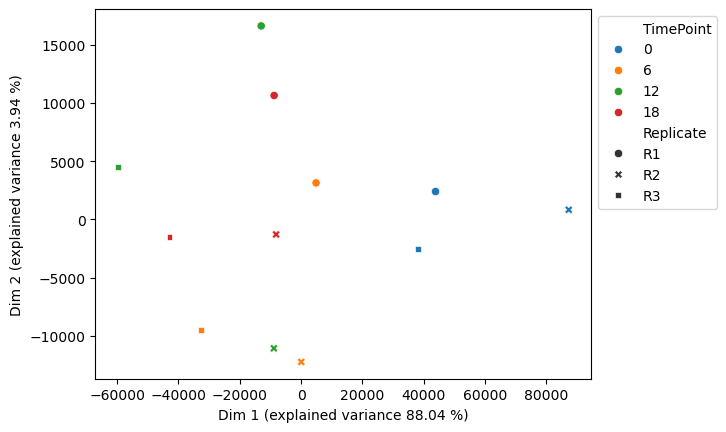

In [21]:
txPCA(tpms[columnOrder])

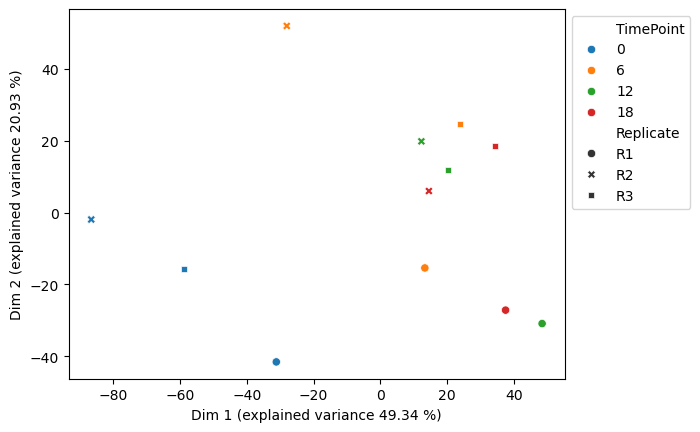

In [22]:
txPCA(logs[columnOrder])

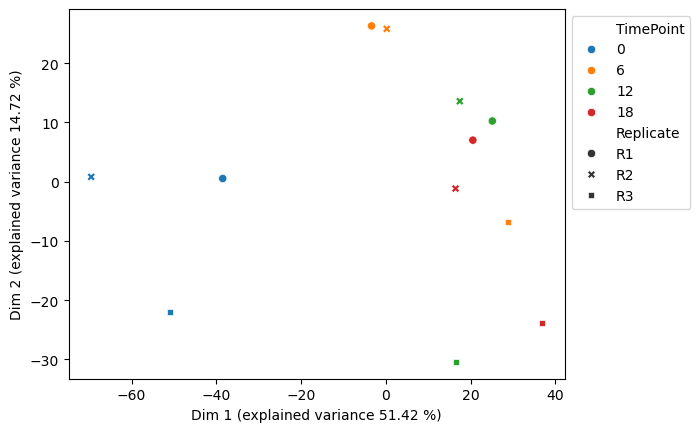

In [23]:
txPCA(logTPMs[columnOrder])

In [24]:
tpmHost = tpms[tpms['Entity'] == 'host']
tpmPhage = tpms[tpms['Entity'] == 'phage']
logTPMsHost = logTPMs[logTPMs['Entity'] == 'host']
logTPMsPhage = logTPMs[logTPMs['Entity'] == 'phage']

tpmHost

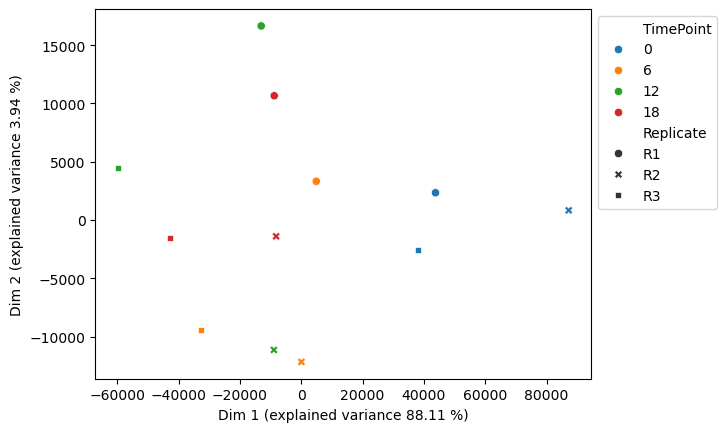

In [25]:
txPCA(tpmHost[columnOrder])

tpmPhage

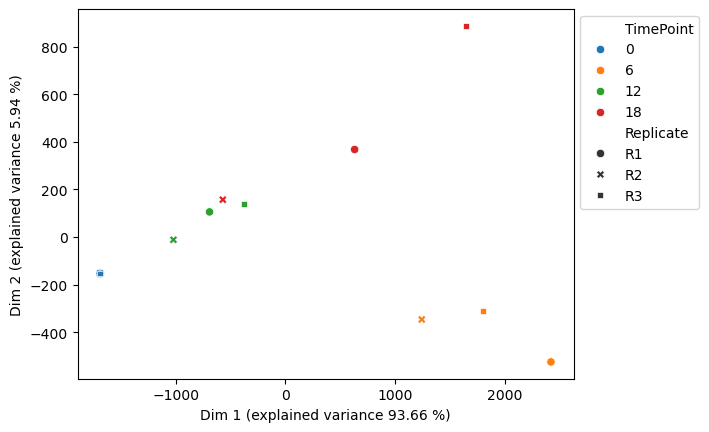

In [26]:
txPCA(tpmPhage[columnOrder])

logTPM Host

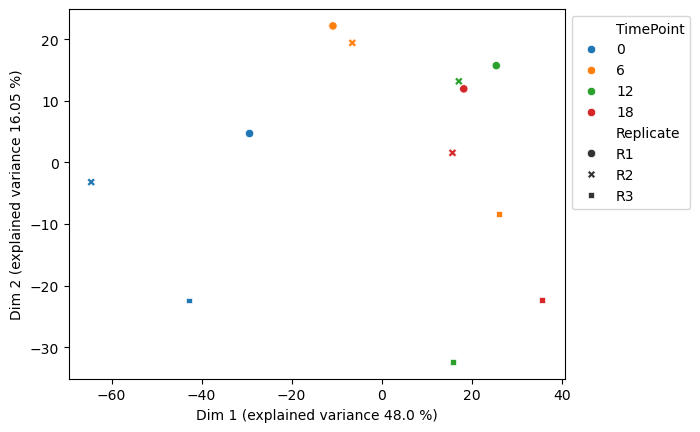

In [27]:
txPCA(logTPMsHost[columnOrder])

logTPM Phage

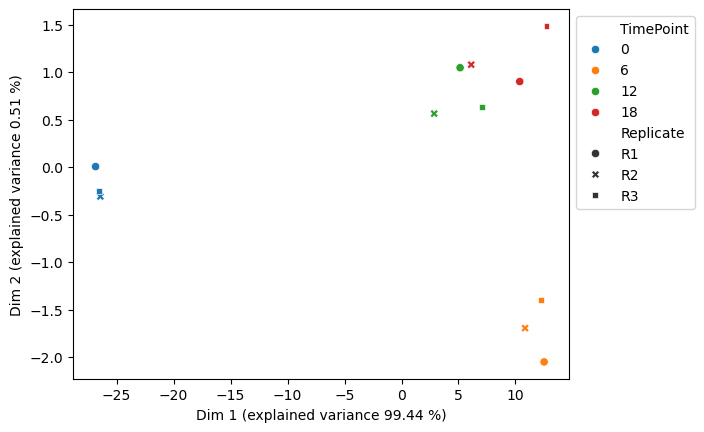

In [28]:
txPCA(logTPMsPhage[columnOrder])

$\rightarrow$ PCA's look all over the place. Try to remove R3 from timepoints 6, 12 and 18.

## 3.2 PCA's without 6_R3, 12_R3, 18_R3

In [29]:
updatedOrder = ['0_R1', '0_R2', '0_R3', '6_R1', '6_R2', '12_R1', '12_R2', '18_R1', '18_R2']

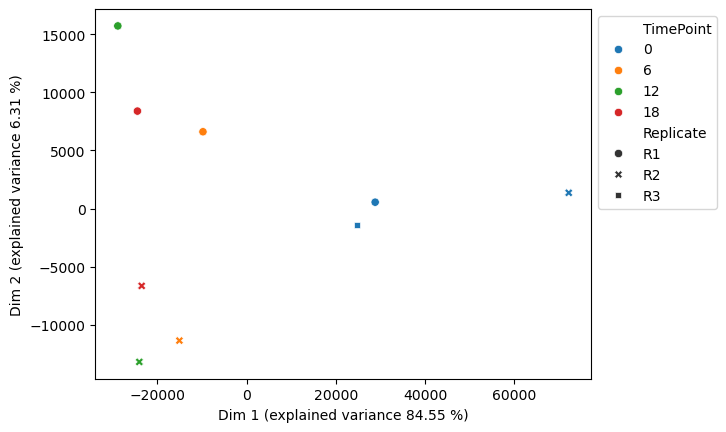

In [30]:
txPCA(tpms[updatedOrder])

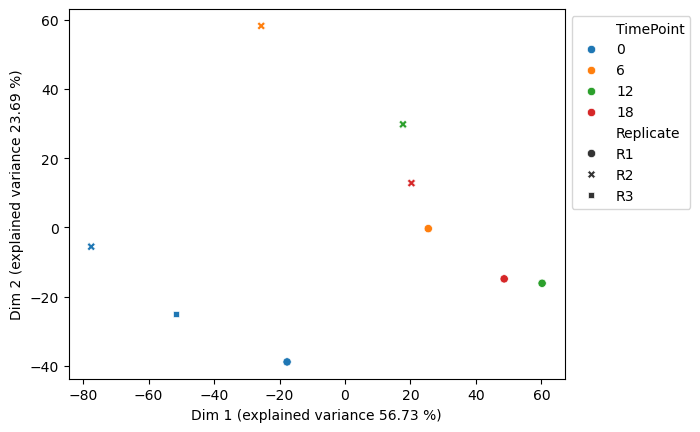

In [31]:
txPCA(logs[updatedOrder])

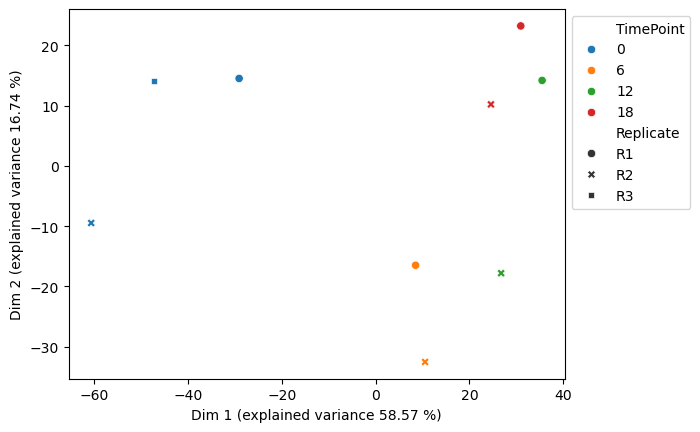

In [32]:
txPCA(logTPMs[updatedOrder])

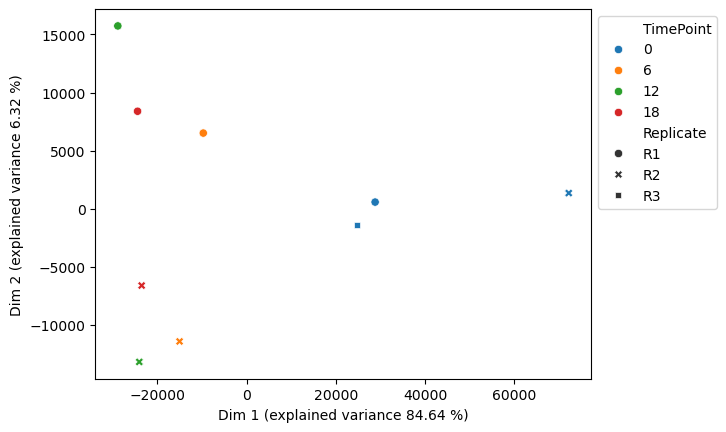

In [33]:
txPCA(tpmHost[updatedOrder])

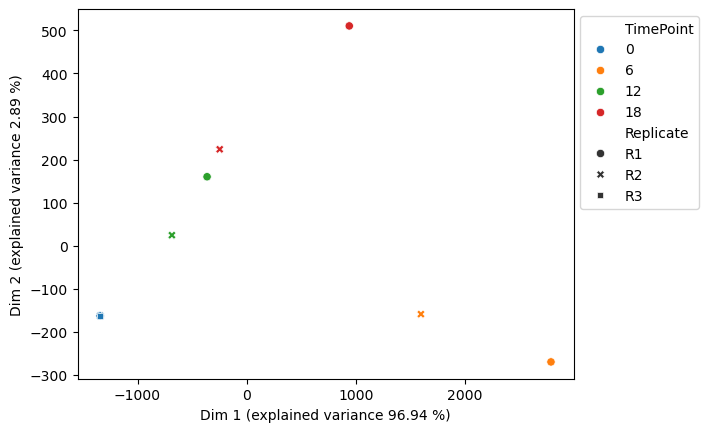

In [34]:
txPCA(tpmPhage[updatedOrder])

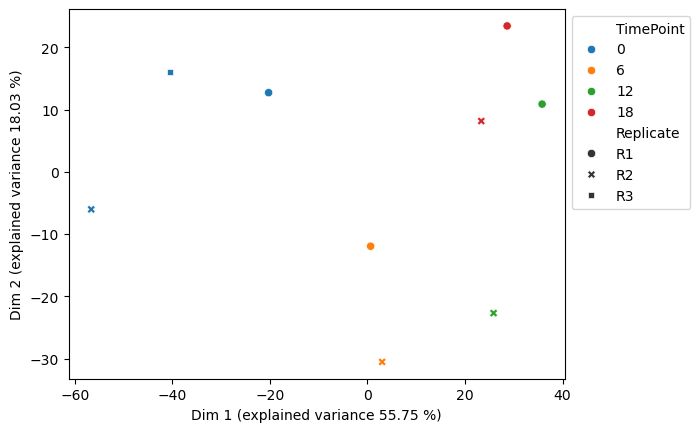

In [35]:
txPCA(logTPMsHost[updatedOrder])

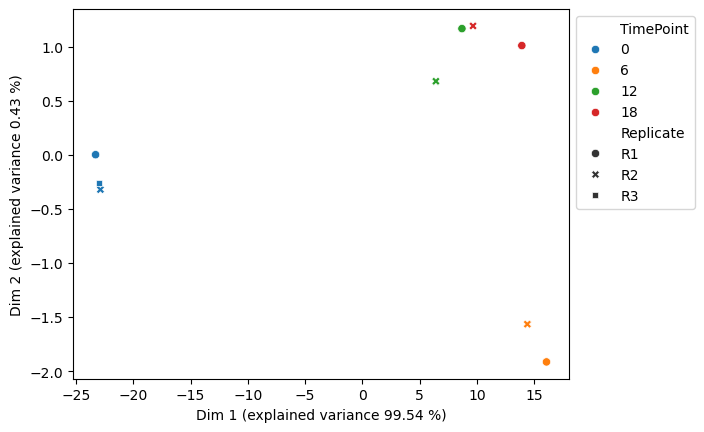

In [36]:
txPCA(logTPMsPhage[updatedOrder])

Separation along Dim1 better, bit more structure in PCA's. I would remove those 3 R3's.

## 4. Final grouping

Summarize time points with mean and standard deviation for TPM-normalized data.

In [37]:
logsUpdated = logs.drop(columns=['6_R3', '12_R3', '18_R3'], axis = 1)
tpmsUpdated = tpms.drop(columns=['6_R3', '12_R3', '18_R3'], axis = 1)

In [38]:
TPMmeans, TPMsds = getMeanSD(tpmsUpdated[updatedOrder])
TPMmeans = TPMmeans[['0', '6', '12', '18']]
TPMmeans[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMmeans

,0,6,12,18,Entity,Symbol
Geneid,,,,,,
gene-PA4720,38.330536,104.066811,106.422919,94.301164,host,trmA
gene-PA4541.2,402.610142,427.975338,434.454710,499.310669,host,gene-PA4541.2
gene-PA2976,151.207472,257.945699,233.154347,216.780611,host,rne
gene-PA0023,50.333875,24.225316,20.981064,24.057822,host,qor
gene-PA2921,6.411089,5.634635,4.766733,5.039677,host,gene-PA2921
...,...,...,...,...,...,...
gene-PA2476,10.467720,8.552893,8.967266,8.429632,host,dsbG
gene-PA0797,16.175709,55.301965,22.423921,12.645796,host,gene-PA0797
gene-PA1656,109.758115,153.345811,104.140818,48.786000,host,gene-PA1656


In [39]:
TPMsds = TPMsds[['0', '6', '12', '18']]
TPMsds[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMsds

,0,6,12,18,Entity,Symbol
Geneid,,,,,,
gene-PA4720,3.174447,31.610997,14.587146,0.025951,host,trmA
gene-PA4541.2,178.098205,37.831137,194.392039,41.901877,host,gene-PA4541.2
gene-PA2976,20.718802,1.457383,11.936439,12.271993,host,rne
gene-PA0023,5.968285,4.848346,1.414649,4.590470,host,qor
gene-PA2921,1.405235,0.840099,0.564722,0.713406,host,gene-PA2921
...,...,...,...,...,...,...
gene-PA2476,1.091101,1.655864,0.193588,2.469013,host,dsbG
gene-PA0797,6.121013,20.600548,4.061826,2.012714,host,gene-PA0797
gene-PA1656,62.446788,73.553354,19.621531,9.302245,host,gene-PA1656


In [40]:
propExp = proportionalExp(TPMmeans[['0', '6', '12', '18']])
propExp[['Entity', 'Symbol']] = TPMmeans[['Entity', 'Symbol']]
propExp

,0,6,12,18,Entity,Symbol
Geneid,,,,,,
gene-PA4720,0.360172,0.977861,1.000000,0.886098,host,trmA
gene-PA4541.2,0.806332,0.857132,0.870109,1.000000,host,gene-PA4541.2
gene-PA2976,0.586199,1.000000,0.903889,0.840412,host,rne
gene-PA0023,1.000000,0.481292,0.416838,0.477965,host,qor
gene-PA2921,1.000000,0.878889,0.743514,0.786088,host,gene-PA2921
...,...,...,...,...,...,...
gene-PA2476,1.000000,0.817073,0.856659,0.805298,host,dsbG
gene-PA0797,0.292498,1.000000,0.405481,0.228668,host,gene-PA0797
gene-PA1656,0.715756,1.000000,0.679124,0.318144,host,gene-PA1656


## 5. Phage gene classification

Similar to Sprenger VP882_WT, no classification specified in paper. Thus 0 -> early, 30 -> middle, 60 -> late.

In [41]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelThreshold(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-2)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM*0.2

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x >= thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('None')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('middle')
        elif timePoint == 3:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassThreshold'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassThreshold'] = 'None'

    return tpmOut

In [42]:
# # Export fractional expressions with T=0.6 + Host/Phage Annotation for Orthofinder Analysis
# t = classLabelThreshold(propExp)
# t = t[t["Entity"] == "phage"]
# t["Host"] = "Pseudomonas_aeruginosa_PAO1_WT"
# t["Phage"] = "Pseudomonas_phage_phiYY"
# t.to_csv("/ceph/ibmi/studenten/waffen/Cross_Analysis/Orthofinder_Clustering/Fractional_Expressions/T060/Zhong_fractional_expression_T=0.6.tsv", sep="\t")

In [43]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelMax(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-3)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x == thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('None')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('middle')
        elif timePoint == 3:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassMax'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassMax'] = 'None'

    return tpmOut

In [44]:
TPMmeans = classLabelThreshold(TPMmeans)
TPMmeans = classLabelMax(TPMmeans)

In [45]:
TPMmeans[TPMmeans['Entity'] == 'phage']

,0,6,12,18,Entity,Symbol,ClassThreshold,ClassMax
Geneid,,,,,,,,
gene-phiYY_sS2,0.308105,1801.246221,424.984757,873.741540,phage,gene-phiYY_sS2,early,early
gene-phiYY_sS3,0.186484,1121.155812,219.512048,438.720525,phage,gene-phiYY_sS3,early,early
gene-phiYY_sM1,0.069556,492.304617,89.064230,196.483423,phage,gene-phiYY_sM1,early,early
gene-phiYY_sL2,0.056509,317.949660,210.477383,408.668558,phage,gene-phiYY_sL2,early,late
gene-phiYY_sL5,0.017584,106.631865,57.104955,136.952502,phage,gene-phiYY_sL5,early,late
gene-phiYY_sL4,0.025759,167.419567,104.100302,204.142195,phage,gene-phiYY_sL4,early,late
gene-phiYY_sL1,0.086937,365.008219,258.071703,539.774702,phage,gene-phiYY_sL1,early,late
gene-phiYY_sL3,0.020935,178.331823,109.428766,213.133822,phage,gene-phiYY_sL3,early,late
gene-phiYY_sS8,0.142455,1089.209717,246.795474,463.217767,phage,gene-phiYY_sS8,early,early


In [46]:
TPMmeans[TPMmeans['Entity'] == 'phage']['ClassMax'].value_counts()

ClassMax
early    13
late      5
Name: count, dtype: int64

Add classes to other dfs.

In [47]:
TPMsds[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
tpmsUpdated[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
logsUpdated[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
propExp[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]

# gff3
gff3_final = gff3_genes.merge(TPMmeans[["ClassThreshold", "ClassMax"]], right_index=True, left_on="ID", how="left")
gff3_host  = gff3_final[gff3_final['seq_id'] == 'NC_002516.2']
gff3_phage = gff3_final[gff3_final['seq_id'] != 'NC_002516.2']
gff3_genes["seq_id"].unique()

array(['NC_002516.2', 'KX074203.1', 'KX074202.1', 'KX074201.1'],
      dtype=object)

## 6. Add variance to all dataframes

Base variance call on tpms.

In [48]:
def stabilizedVariance(df):
    labels = list()
    
    i = 0
    while i < df.shape[0]:

        # Get array of expression values at time points
        expressions = list(df.iloc[i,0:(df.shape[1]-4)])

        # Get mean expression for the gene
        exprMean = np.mean(np.array(expressions))

        # Get the variance for the gene
        varGene = np.var(np.array(expressions))

        # Stabilized variance
        stableVarGene = varGene/exprMean

        labels.append(stableVarGene)

        i += 1

    tpmOut = df.copy()
    tpmOut['Variance'] = labels

    return tpmOut

In [49]:
tpmsUpdated = stabilizedVariance(tpmsUpdated)
tpmsUpdated

SampleNames,0_R1,0_R2,0_R3,6_R1,6_R2,12_R1,12_R2,18_R1,18_R2,Entity,Symbol,ClassThreshold,ClassMax,Variance
Geneid,,,,,,,,,,,,,,
gene-PA4720,33.986574,39.521107,41.483926,72.455814,135.677808,121.010065,91.835774,94.275213,94.327115,host,trmA,None,None,14.663569
gene-PA4541.2,240.784864,316.376468,650.669095,465.806475,390.144202,240.062672,628.846749,541.212546,457.408792,host,gene-PA4541.2,None,None,47.972821
gene-PA2976,176.314555,151.735555,125.572306,256.488316,259.403082,245.090786,221.217909,204.508617,229.052604,host,rne,None,None,9.608757
gene-PA0023,43.393086,57.963564,49.644977,19.376969,29.073662,19.566416,22.395713,19.467351,28.648292,host,qor,None,None,5.864801
gene-PA2921,7.707552,7.067241,4.458474,4.794537,6.474734,4.202010,5.331455,4.326272,5.753083,host,gene-PA2921,None,None,0.258900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PA2476,11.412971,11.051327,8.938862,6.897029,10.208757,8.773678,9.160854,5.960619,10.898645,host,dsbG,None,None,0.339104
gene-PA0797,20.074883,20.919218,7.533027,34.701417,75.902514,18.362095,26.485747,14.658510,10.633082,host,gene-PA0797,None,None,14.780732
gene-PA1656,197.052086,77.696638,54.525622,226.899164,79.792457,123.762349,84.519287,58.088245,39.483755,host,gene-PA1656,None,None,36.657765


In [50]:
logsUpdated['Variance'] = tpmsUpdated['Variance']
TPMmeans['Variance'] = tpmsUpdated['Variance']
TPMsds['Variance'] = tpmsUpdated['Variance']
propExp['Variance'] = tpmsUpdated['Variance']

## 7. Write data to output

In [51]:
df_norRNAs[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
df_norRNAsUpdated = df_norRNAs.drop(columns=['6_R3', '12_R3', '18_R3'], axis=1)
df_norRNAsUpdated

SampleNames,0_R1,0_R2,0_R3,6_R1,6_R2,12_R1,12_R2,18_R1,18_R2,Entity,Symbol
Geneid,,,,,,,,,,,
gene-PA4720,571,934,877,1108,4056,1826,1966,1646,2016,host,trmA
gene-PA4541.2,285,527,970,502,822,255,949,666,689,host,gene-PA4541.2
gene-PA2976,8617,10428,7720,11405,22542,10752,13768,10381,14232,host,rne
gene-PA0023,653,1227,940,265,778,264,429,304,548,host,qor
gene-PA2921,117,151,85,66,175,57,103,68,111,host,gene-PA2921
...,...,...,...,...,...,...,...,...,...,...,...
gene-PA2476,135,184,133,74,215,93,138,73,164,host,dsbG
gene-PA0797,223,327,105,351,1502,183,375,169,150,host,gene-PA0797
gene-PA1656,4724,2619,1644,4949,3401,2663,2580,1446,1203,host,gene-PA1656


In [52]:
# Full TPM table
tpmsUpdated.to_csv('Zhong_full_TPM.tsv', sep = '\t')
# Full raw_counts table
df_norRNAs.to_csv('Zhong_full_raw_counts.tsv', sep = '\t')
# Summarized (time point means) TPM table
TPMmeans.to_csv('Zhong_TPM_means.tsv', sep = '\t')
# Summarized (time point) TPM standard deviation
TPMsds.to_csv('Zhong_TPM_std.tsv', sep = '\t')
# Proportional expression per gene and time point
propExp.to_csv('Zhong_fractional_expression.tsv', sep = '\t')
# Processed gff3 file
gff3_host.to_csv('Zhong_host_gff3.tsv', sep='\t')
gff3_phage.to_csv('Zhong_phage_gff3.tsv', sep='\t')

In [53]:
from scipy.stats import zscore
t = tpms[tpms["Entity"] == 'phage']
t = t.drop(columns=['Entity', 'Symbol'])
t = t.sub(t.mean(axis=1), axis=0).div(t.std(axis=1), axis=0)

Text(0.5, 1.0, 'Heatmap with Matplotlib')

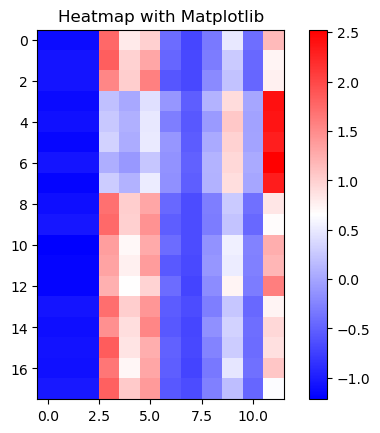

In [54]:
plt.imshow(t, cmap='bwr', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap with Matplotlib')

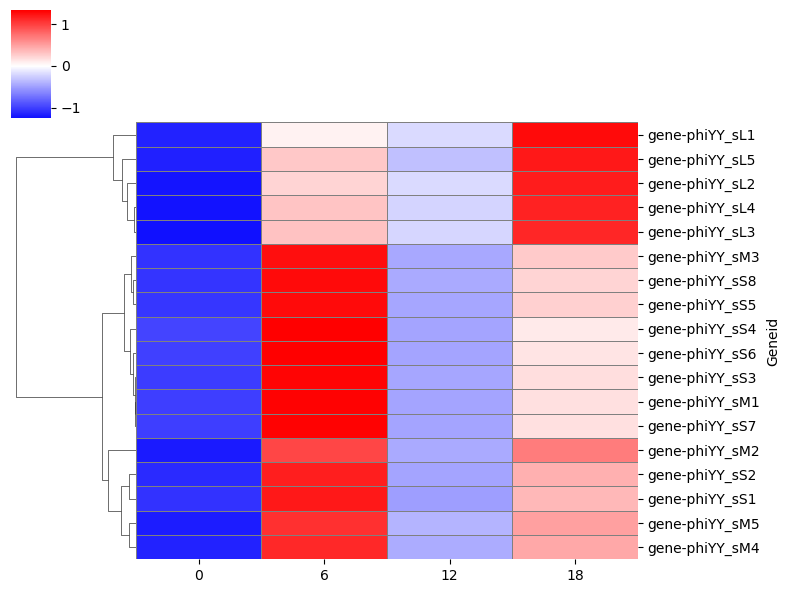

In [55]:
import seaborn as sns

tm, td = getMeanSD(tpms[tpms['Entity'] == 'phage'][columnOrder])
tm = tm[['0', '6', '12', '18']]
tm = tm.sub(tm.mean(axis=1), axis=0).div(tm.std(axis=1), axis=0)

sns.clustermap(tm, cmap='bwr', center=0, figsize=(8, 6), 
               row_cluster=True, col_cluster=False, 
               linewidths=0.5, linecolor='gray')